In [1]:
import numpy as np 
import pandas as pd 

df = pd.read_csv("/kaggle/input/support-ticket-priority-dataset-50k/Support_tickets.csv")
df.head(3)

,ticket_id,day_of_week,day_of_week_num,company_id,company_size,company_size_cat,industry,industry_cat,customer_tier,customer_tier_cat,...,downtime_min,payment_impact_flag,security_incident_flag,data_loss_flag,has_runbook,customer_sentiment,customer_sentiment_cat,description_length,priority,priority_cat
0,1000000000,Wed,3,100015,Small,1,media,7,Basic,1,...,6,0,0,0,0,neutral,2,227,low,1
1,1000000001,Sat,6,100023,Small,1,healthcare,5,Basic,1,...,2,0,0,0,0,neutral,2,461,low,1
2,1000000002,Mon,1,100012,Small,1,gaming,4,Basic,1,...,0,0,0,0,1,positive,3,306,low,1


In [2]:
num_df = df.select_dtypes(include=["number"]).copy()
num_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ticket_id               50000 non-null  int64  
 1   day_of_week_num         50000 non-null  int64  
 2   company_id              50000 non-null  int64  
 3   company_size_cat        50000 non-null  int64  
 4   industry_cat            50000 non-null  int64  
 5   customer_tier_cat       50000 non-null  int64  
 6   org_users               50000 non-null  int64  
 7   region_cat              50000 non-null  int64  
 8   past_30d_tickets        50000 non-null  int64  
 9   past_90d_incidents      50000 non-null  int64  
 10  product_area_cat        50000 non-null  int64  
 11  booking_channel_cat     50000 non-null  int64  
 12  reported_by_role_cat    50000 non-null  int64  
 13  customers_affected      50000 non-null  int64  
 14  error_rate_pct          50000 non-null

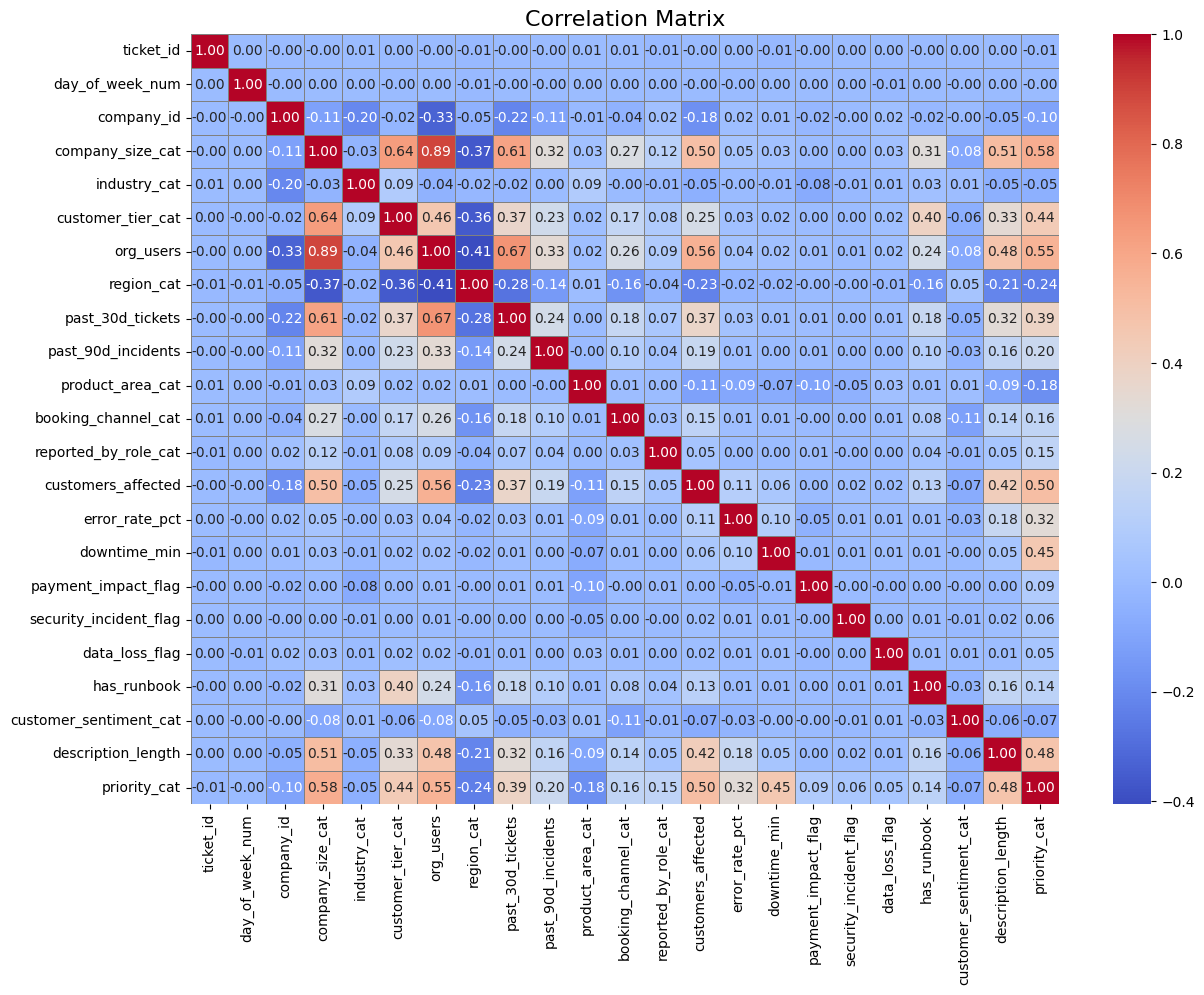

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = num_df.corr(numeric_only=True)

plt.figure(figsize=(14,10))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
    linecolor="gray",
    cbar=True
)
plt.title("Correlation Matrix", fontsize=16)
plt.show()

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import perf_counter

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

SEED = 2025

X = num_df.drop(columns=["priority_cat"])
y = num_df["priority_cat"].astype(int).values  
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=SEED
)

kernels = {
    "linear": {
        "base": SVC(kernel="linear", random_state=SEED),
        "grid": {
            "svc__C": [0.5, 1, 2, 4],
            "svc__class_weight": [None, "balanced"]
        }
    },
    "rbf": {
        "base": SVC(kernel="rbf", random_state=SEED),
        "grid": {
            "svc__C": [0.5, 1, 2, 4],
            "svc__gamma": ["scale", 0.1, 0.01],
            "svc__class_weight": [None, "balanced"]
        }
    },
    "poly": {
        "base": SVC(kernel="poly", random_state=SEED),
        "grid": {
            "svc__C": [0.5, 1, 2, 4],
            "svc__degree": [2, 3, 4],
            "svc__gamma": ["scale", 0.1, 0.01],
            "svc__coef0": [0.0, 0.5, 1.0],
            "svc__class_weight": [None, "balanced"]
        }
    },
    "sigmoid": {
        "base": SVC(kernel="sigmoid", random_state=SEED),
        "grid": {
            "svc__C": [0.5, 1, 2, 4],
            "svc__gamma": ["scale", 0.1, 0.01],
            "svc__coef0": [-1.0, 0.0, 1.0],
            "svc__class_weight": [None, "balanced"]
        }
    }
}

results = []

for kname, spec in kernels.items():
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("svc", spec["base"])
    ])

    grid = GridSearchCV(
        estimator=pipe,
        param_grid=spec["grid"],
        scoring="accuracy",   
        cv=4,
        n_jobs=-1,
        refit=True,
        verbose=0
    )

    t0 = perf_counter()
    grid.fit(X_train, y_train)
    t1 = perf_counter()

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    results.append({
        "kernel": kname,
        "cv_best_score": grid.best_score_,
        "test_accuracy": acc,
        "fit_seconds": (t1 - t0),
        "best_params": grid.best_params_
    })

    print(f"✅ {kname.upper()} done in {t1 - t0:.2f}s | "
          f"CV(best)={grid.best_score_:.4f} | Test Acc={acc:.4f}")

results_df = pd.DataFrame(results).sort_values("test_accuracy", ascending=False)
results_df


✅ LINEAR done in 545.39s | CV(best)=0.8539 | Test Acc=0.8558
✅ RBF done in 1106.80s | CV(best)=0.9007 | Test Acc=0.9077
✅ POLY done in 12287.99s | CV(best)=0.9179 | Test Acc=0.9278
✅ SIGMOID done in 4009.82s | CV(best)=0.8724 | Test Acc=0.8771


,kernel,cv_best_score,test_accuracy,fit_seconds,best_params
2,poly,0.91790,0.9278,12287.992753,"{'svc__C': 4, 'svc__class_weight': None, 'svc_..."
1,rbf,0.90070,0.9077,1106.797764,"{'svc__C': 4, 'svc__class_weight': None, 'svc_..."
3,sigmoid,0.87245,0.8771,4009.815626,"{'svc__C': 4, 'svc__class_weight': None, 'svc_..."
0,linear,0.85390,0.8558,545.385635,"{'svc__C': 4, 'svc__class_weight': None}"


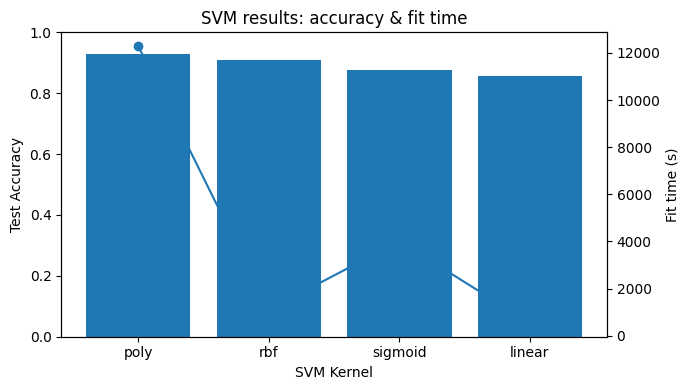

In [5]:
fig, ax1 = plt.subplots(figsize=(7,4))
order = results_df["kernel"].tolist()
accs = results_df["test_accuracy"].values
times = results_df["fit_seconds"].values

ax1.bar(order, accs)
ax1.set_ylabel("Test Accuracy")
ax1.set_ylim(0.0, 1.0)
ax1.set_xlabel("SVM Kernel")
ax1.set_title("SVM results: accuracy & fit time")

ax2 = ax1.twinx()
ax2.plot(order, times, marker="o")
ax2.set_ylabel("Fit time (s)")

plt.tight_layout()
plt.show()
